In [180]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os
import seaborn as sns
import umap
import csv
import warnings
from collections import OrderedDict
from collections import defaultdict
from scipy import signal, stats
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler

plt.rcParams.update({'figure.max_open_warning': 0})
warnings.simplefilter("ignore")

%run /media/turritopsis/katie/grooming/t1-grooming/grooming_functions.ipynb
%matplotlib inline

# for figure styling and saving
sns.set()
sns.set_style('ticks')
out_path = '/media/turritopsis/katie/grooming/dim_reduction'

In [4]:
def get_nmodes(s, thresh = 0.8):
    nmodes = len(s)
    for j in range(len(s)):
        energy = np.sum(np.dot(s[:j], s[:j])) / np.sum(s)
        if energy > thresh:
            nmodes = j
            break
    return nmodes

def mplot(matrix, approx):
    sns.set()
    sns.set_style('ticks')
    fig = plt.figure()
    ax0 = fig.add_subplot(1,2,1)
    ax0.set_title('True Matrix')
    ax0.imshow(matrix, cmap = 'gray')
    ax1 = fig.add_subplot(1,2,2)
    ax1.set_title('Low Rank Approximation')
    ax1.imshow(approx, cmap = 'gray')
    
def mplot_diff(matrix, approx):
    matrix_norm = matrix / np.amax(matrix)
    approx_norm = approx / np.amax(approx)
    sns.set()
    sns.set_style('ticks')
    fig = plt.figure()
    ax = plt.gca()
    ax.set_title('True Matrix - Low Rank Approximation', fontsize = 14)
    plt.xticks([])
    plt.yticks([])
    im = ax.imshow(matrix_norm-approx_norm, cmap = 'coolwarm', vmin = -1, vmax = 1)
    cax = fig.add_axes()
    cbar = fig.colorbar(im, orientation = 'vertical', cax = cax, fraction=0.04, pad=0.03)
    # plt.savefig(os.path.join(path, r'A_diff_small.png'), dpi = 400)
    plt.show()

def plot_singular_values(s):
    fig = plt.figure()
    plt.title('Singular Values of Input Matrix', fontsize = 14)
    plt.ylabel('Singular Value', fontsize = 14)
    plt.xlabel('Index', fontsize = 14)
    ax = plt.gca()
    ax.scatter(range(len(s)), s, edgecolor = 'k', facecolor = 'w')
    # plt.savefig(os.path.join(path, r'X_singular_values.png'), dpi = 400)
    plt.show()

In [131]:
# dmdc algorithm functions 

# svd on input space
def svd_input(omega, p): 
    
    U, s, VH = np.linalg.svd(omega, full_matrices = False)
    V = VH.conj().T
    UH = U.conj().T
    
    # p = get_nmodes(s, thresh = 0.5)
    #if p < X.shape[0]:
    #    p = X.shape[0]
    S = np.diag(s)
    np.allclose(omega, np.dot(U * s, VH))

    U_p = U[:, :p]
    S_p = S[:p, :p] 
    VH_p = VH[:p, :] 
    V_p = V[:, :p]  
    UH_p = UH[:p, :] 
    
    return s, U_p, S_p, VH_p, V_p, UH_p

# SVD on output space
def svd_output(Xp, r):

    U, s, VH = np.linalg.svd(Xp, full_matrices = False)
    V = VH.conj().T
    UH = U.conj().T
    
    # r = get_nmodes(s, thresh = 0.8)
    S = np.diag(s)
    np.allclose(Xp, np.dot(U * s, VH))
    
    U_r = U[:, :r]
    S_r = S[:r, :r] 
    VH_r = VH[:r, :] 
    V_r = V[:, :r]  
    UH_r = UH[:r, :]  

    return s, U_r, S_r, VH_r, V_r, UH_r

#compute approximation of G = [A, B]    
def approx_operators(X, Y, Xp, V_p, S_p, UH_p, U_r, UH_r):
    
    A_bar = np.dot(Xp, np.dot(V_p, np.dot(np.linalg.inv(S_p), UH_p[:, :X.shape[0]])))
    A_tilde = np.dot(UH_r, np.dot(A_bar, U_r))   
    B_bar = np.dot(Xp, np.dot(V_p, np.dot(np.linalg.inv(S_p), UH_p[:, :Y.shape[0]])))
    B_tilde = np.dot(UH_r, B_bar)
    
    return A_bar, A_tilde, B_bar, B_tilde


def get_dmd_modes(X, Xp, A_tilde, V_p, S_p, UH_p, U_r, dt):
    D, W = np.linalg.eig(A_tilde)
    phi = np.dot(Xp, np.dot(V_p, np.dot(np.linalg.inv(S_p), UH_p[:, :X.shape[0]])))
    phi = np.dot(phi, np.dot(U_r, W))
    omega_t = np.log(abs(D)) / dt
    return omega_t, phi

# reconstruct original data matrix
def dmd_reconstruction(t, r, X, omega_t, phi):
    x1 = X[:, 0]
    b = np.linalg.lstsq(phi, x1[:,None])
    dynamics = np.zeros([r, len(t)])
    # plt.plot(np.real(vv[:,0:r]))
    for j in range(len(t)): 
        dynamics[:, j][:, None] = b[0]*np.exp(np.dot(omega_t,t[j]))[:, None]
    X_dmd = np.dot(phi, dynamics)
    
    return X_dmd, dynamics

# time based features
def time_features_old(data, angles, filenames, nperseg, noverlap):
    
    X_list = []
    angle_types = np.array(['_BC', '_flex', '_rot'])
    angle_names = get_angle_names(angles, angle_types)
    
    for filename in filenames:
        sub_ixs = data['filename'] == filename
        # X_sub = data.loc[sub_ixs, bodyparts_xyz]
        X_sub = np.array(angles.loc[sub_ixs, angle_names])
    
        for i in range(0, X_sub.shape[0], noverlap):
            if X_sub.shape[0] > i+nperseg:
                X_list.append(X_sub[i:i+nperseg].T)
    
    X_times = np.array(X_list)
    
    return X_times

def time_features(data, angle_vars, window_size=32, noverlap=8):

    bout_numbers = np.unique(data['behavior_bout'].astype(int))
    hanning = signal.windows.hann(window_size)
    X_list = []
    rows = []
    
    for j in range(len(bout_numbers)):
        d = data.loc[data['behavior_bout'] == bout_numbers[j]]
        X_in = np.array(d.loc[:, angle_vars])
        
        for i in range(0, X_in.shape[0]-window_size+1, noverlap):
            row = dict(d.iloc[i+window_size//2]) # takes value from middle of the window by default
            row['bout_len'] = len(X_in)
            vals = X_in[i:i+window_size].T
            X_list.append(vals)
            rows.append(row)

    X_times = np.array(X_list)
    X_times = X_times.reshape(X_times.shape[0], -1)

    return X_times

(551, 256)

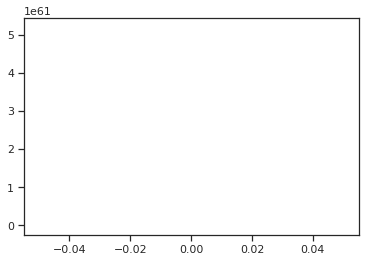

In [151]:
x1 = X[:, 0]
b = np.linalg.lstsq(phi, x1[:,None])
dynamics = np.zeros([r, len(t)])
for j in range(len(t)): 
    dynamics[:, j][:, None] = b[0]*np.exp(np.dot(abs(omega_t),t[j]))[:, None]
    plt.plot(dynamics[:, j])
X_dmd = np.dot(phi, dynamics)

In [6]:
# load data
def adjust_rot_angles(angles, angle_names):
    conds = ['2', '3', 'L1A', 'L1B', 'L1C', 'R1A', 'R1B', 'R1C']
    offsets = np.array([-50, -20, 20, -70, 10, 20, 70, -30])
    for j in range(len(conds)):
        rot_angs = [r for r in angle_names if '_rot' in r and conds[j] in r]
        for ang in rot_angs:
            r = np.array(angles[ang])
            r[r > offsets[j]] = r[r > offsets[j]] - 360
            angles[ang] = r
        
    abduct_angs = [r for r in angle_names if '_abduct' in r or 'A_flex' in r]
    for ang in abduct_angs:
        r = np.array(angles[ang])
        r[r > 50] = r[r > 50] - 360
        angles[ang] = r
        
    return angles

prefix = r'/media/turritopsis/pierre/gdrive/latest/behavior/T1_grooming'
data_path = os.path.join(prefix, 'T1_grooming_all.csv.gz')
data = pd.read_csv(data_path, compression = 'gzip')
data['behavior_bout'] = data['T1_grooming_bout_number']
data['flyid'] = data['fly'].astype(str) + ' ' + data['date'].astype(str)
data = data[~data.behavior_bout.isnull()]
data = adjust_bout_numbers(data)
bout_length_dict = get_bout_lengths(data)
data = remove_short_bouts(data, 60)
fps = 300.0 # know this for this dataset

angle_types = np.array(['_BC', '_flex', '_rot', '_abduct'])
angle_names_t1 = get_angle_names(data, angle_types, only_t1 = True)
angle_names = get_angle_names(data, angle_types, only_t1 = False)
data = correct_angles(data, angle_names)
data = adjust_rot_angles(data, angle_names)

In [7]:
angle_vars = [v for v in data.columns
              if some_contains(v, ['_flex', '_rot', '_x', '_y', '_z'])
              and not some_contains(v, ['_d1', '_d2', '_freq', '_range'])
              and v[:2] == 'L1']
features = ['L1B_rot_avg_range', 'L1A_flex_avg_range', 'L1E_z_avg_range', 'L1D_z', 'L1E_z']
flip = [False, False, False, True, True]
data = compute_grooming_scores(data, angle_vars, features, flip = flip, dist=20, norm=False)
data = data[data.grooming_score < 8.25]
data = data[data.grooming_score > 1.6]

bout_numbers = np.unique(np.array(data.behavior_bout))
fly_dict = get_fly_id(data, bout_numbers)
videos = get_videos(bout_numbers, data)
fly_videos = fly_to_video(data)
dif_flies = np.unique(list(fly_dict.values()))
fly_data, fly_names_sorted = data_per_fly(data)

In [183]:
# set up for dmd with control, start with one bout
bout_data = data[data.behavior_bout == 105.0]
angle_vars = np.unique([v for v in data.columns
              if some_contains(v, ['_flex', '_rot', '_abduct'])
              and not some_contains(v, ['_d1', '_d2', '_freq', '_range'])
              and v[:2] in ['L1', 'R1']])

# time based features 
nperseg = 24
noverlap = int(nperseg // 2)
# X = time_features(bout_data, angle_vars, nperseg, noverlap)
X = np.array(bout_data.loc[:, angle_vars]).T
X = StandardScaler().fit_transform(X)
# X = X - X[0]


t = np.linspace(0, 4*np.pi, 256)
dt = t[1] - t[0]
dt = (nperseg - noverlap)/fps

# should the transpose be used?
xh = X.conj().T
X = xh[:, :-1]
Xp = xh[:, 1:]
Y = np.random.random(X.shape)
omega = np.vstack((X,Y))

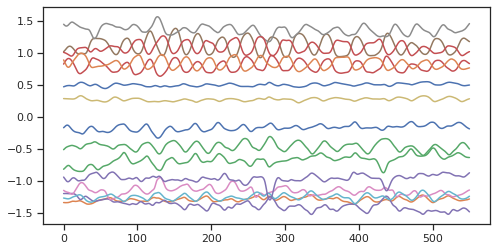

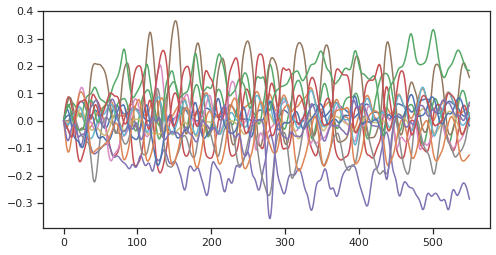

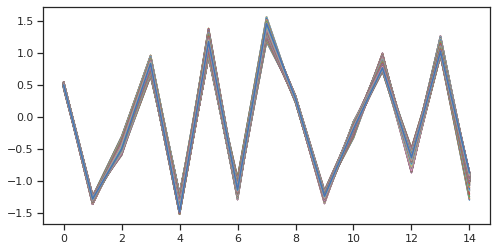

In [184]:
# plot input data
figure = plt.figure(figsize = (8,4))
plt.plot(X)
plt.show()

figure = plt.figure(figsize = (8,4))
plt.plot(X-X[0])
plt.show()

figure = plt.figure(figsize = (8,4))
plt.plot(X.T)
plt.show()

In [185]:
r = 1
p = X.shape[0]

s_input, U_p, S_p, VH_p, V_p, UH_p = svd_input(omega, p)
s_output, U_r, S_r, VH_r, V_r, UH_r = svd_output(Xp, r)
A_bar, A_tilde, B_bar, B_tilde = approx_operators(X, Y, Xp, V_p, S_p, UH_p, U_r, UH_r)
omega_t, phi = get_dmd_modes(X, Xp, A_tilde, V_p, S_p, UH_p, U_r, dt)
X_dmd, dynamics = dmd_reconstruction(t, r, X, omega_t, phi)

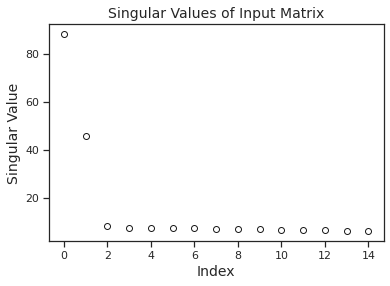

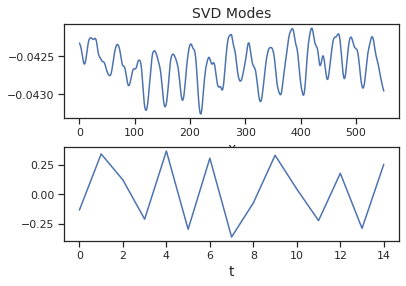

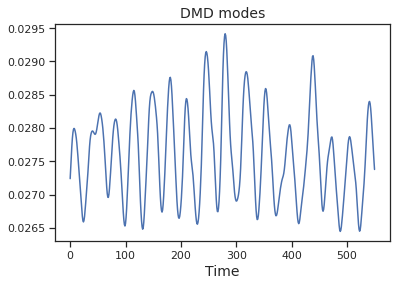

In [186]:
# plot singular values
plot_singular_values(s_input)

# plot SVD modes and temporal dynamics
fig = plt.figure()
uu, ss, vvh = np.linalg.svd(X)
vv = vvh.conj().T
ax = fig.add_subplot(2,1,1)
ax.plot(np.real(uu[:,0:r]))
ax.set_xlabel('x', fontsize = 14)
ax1 = fig.add_subplot(2,1,2)
ax1.plot(np.real(vv[:,0:r]))
ax1.set_xlabel('t', fontsize = 14)
plt.subplots_adjust(hspace = 0.3)
ax.set_title('SVD Modes', fontsize = 14)
# plt.savefig(os.path.join(path, r'X_svd_modes.png'), dpi = 400)
plt.show()

# plot DMD modes
fig = plt.figure()
plt.title('DMD modes', fontsize = 14)
plt.plot(np.real(phi))
plt.xlabel('Time', fontsize = 14)
# plt.savefig(os.path.join(path, r'dmd_modes.png'), dpi = 400)
plt.show()

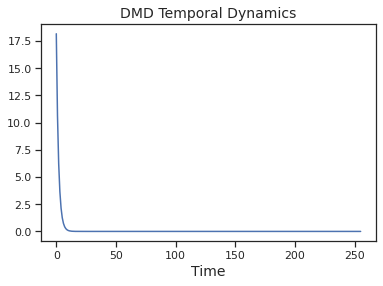

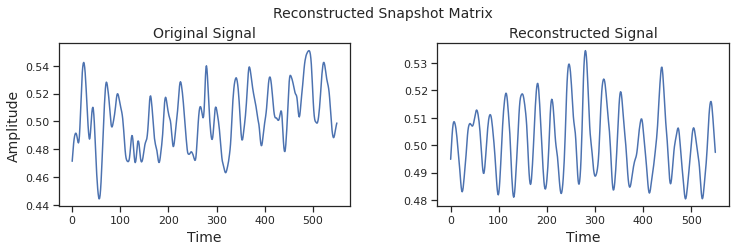

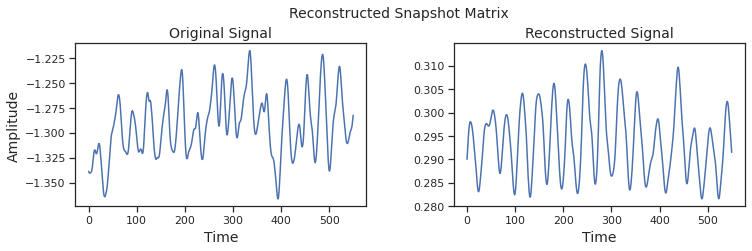

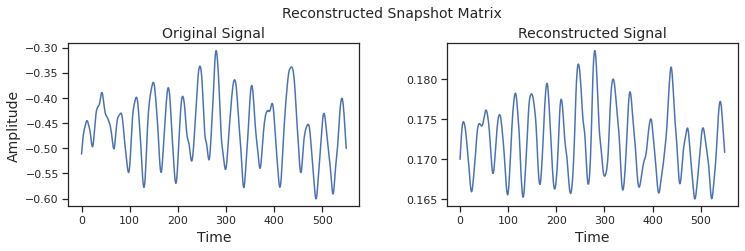

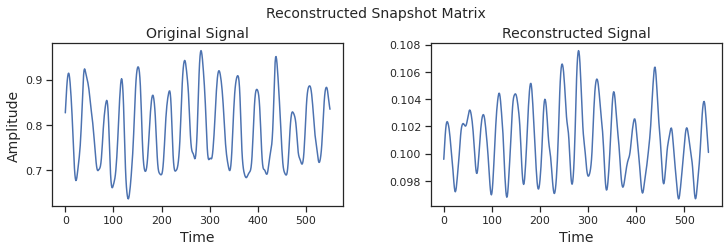

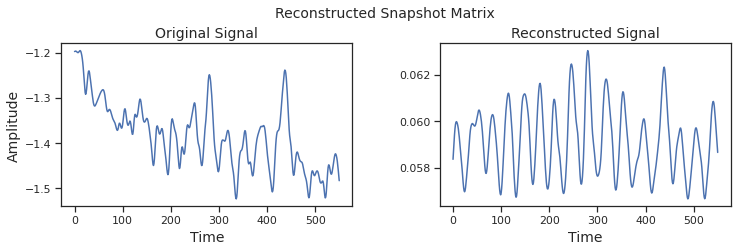

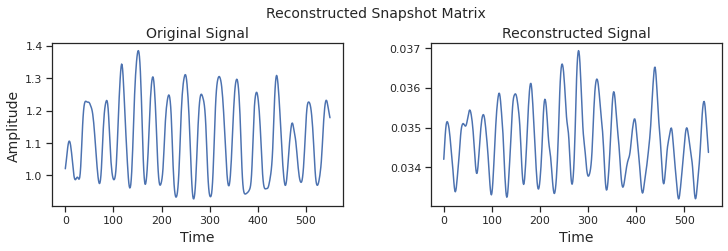

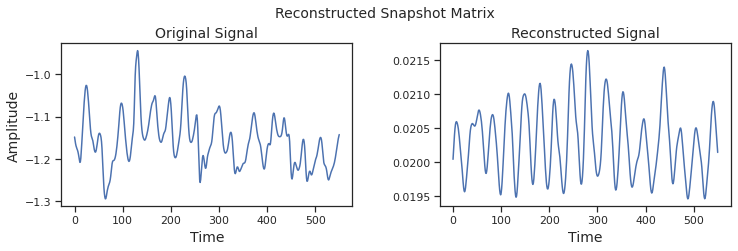

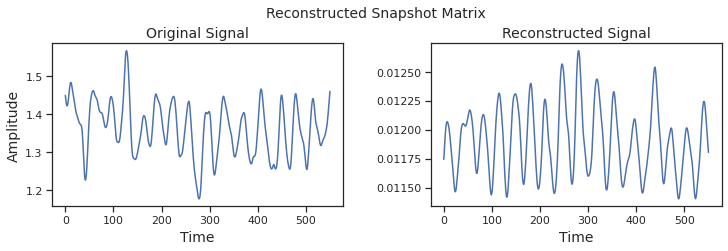

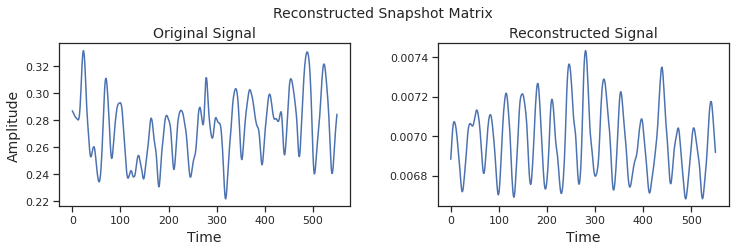

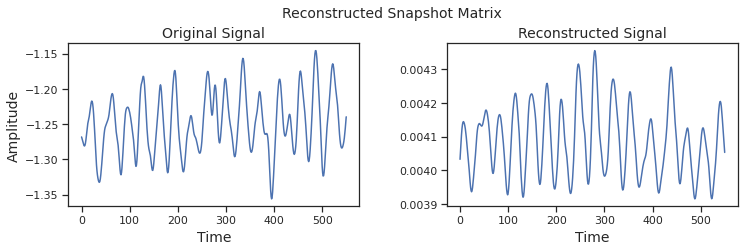

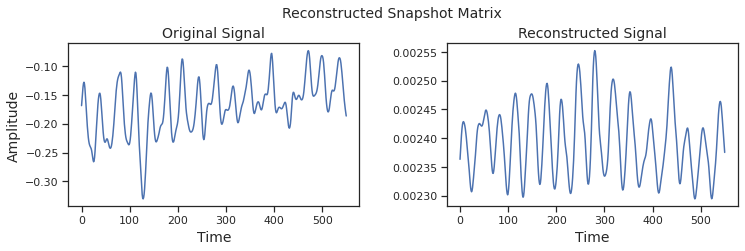

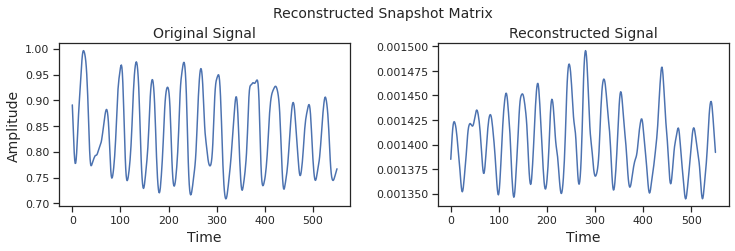

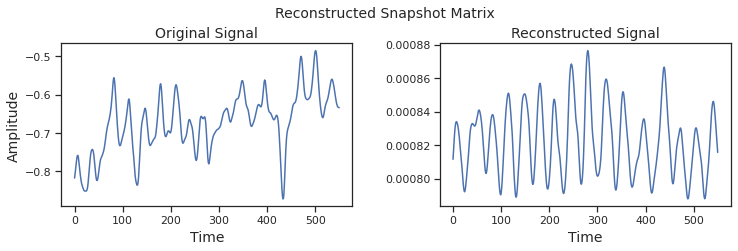

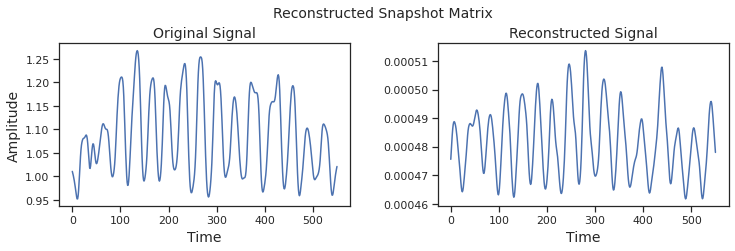

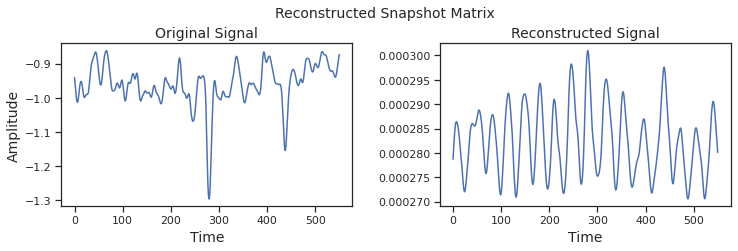

In [189]:
# DMD temporal dynamics and signal reconstruction
fig = plt.figure()
plt.title('DMD Temporal Dynamics', fontsize = 14)
plt.plot(dynamics.T)
plt.xlabel('Time', fontsize = 14)
# plt.savefig(os.path.join(path, r'dmd_temporal_dynamics.png'), dpi = 400)
plt.show()

# reconstruct the original signal
for j in range(X.shape[1]):
    fig = plt.figure(figsize = (12, 3))
    fig.suptitle('Reconstructed Snapshot Matrix', fontsize = 14, y = 1.05)
    ax0 = fig.add_subplot(1, 2, 1)
    ax0.plot(X[:, j])
    ax0.set_xlabel('Time', fontsize = 14)
    ax0.set_ylabel('Amplitude', fontsize = 14)
    ax0.set_title('Original Signal', fontsize = 14)
    # ax0.set_ylim([min(np.min(X), np.min(np.real(X_dmd))), max(np.max(X), np.max(np.real(X_dmd)))])
    ax1 = fig.add_subplot(1, 2, 2)
    ax1.plot(X_dmd[:, j])
    ax1.set_xlabel('Time', fontsize = 14)
    ax1.set_title('Reconstructed Signal', fontsize = 14)
    # ax1.set_ylim([min(np.min(X), np.min(np.real(X_dmd))), max(np.max(X), np.max(np.real(X_dmd)))])
    plt.subplots_adjust(wspace = 0.3)
    plt.show()

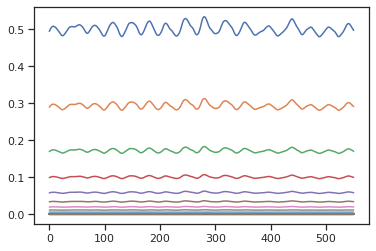

In [188]:
cols = X_dmd.shape[1]
for j in range(cols):
    plt.plot(X_dmd[:, j])